RF PROPAGATION ANALYSIS WITH FRESNEL ZONE CLEARANCE
Transmitter: (21.31708°E, 38.45942°N)
Receiver:    (21.40549°E, 38.41883°N)
Area: ~34.2 km × 28.9 km

[Step 1/6] Downloading Copernicus DEM tiles...
  ✓ Copernicus_DSM_COG_10_N38_00_E021_00_DEM (cached)

✓ Downloaded 1 tile(s)

[Step 2/6] Merging DEM tiles...
✓ Merged DEM: copernicus_dem_30m.tif

[Step 3/6] Extracting elevation profile...
  Path length: 8.935 km
✓ Extracted 500 valid points

[Step 4/6] Calculating Fresnel zones and RF propagation...
  Transmitter elevation: 8.2m + 30m antenna = 38.2m ASL
  Receiver elevation: 350.5m + 10m antenna = 360.5m ASL
  VHF (TV Band III)    |    200.0 MHz | Fresnel:  57.9m | ✗ OBSTRUCTED (1.8%)
  UHF (TV Band IV)     |    470.0 MHz | Fresnel:  37.8m | ✗ OBSTRUCTED (1.6%)
  GSM-900              |    900.0 MHz | Fresnel:  27.3m | ✗ OBSTRUCTED (1.6%)
  GSM-1800             |   1800.0 MHz | Fresnel:  19.3m | ✗ OBSTRUCTED (1.6%)
  LORAN-C              |      0.1 MHz | Fresnel: 2588.7m | ✗ OBSTRUCTE

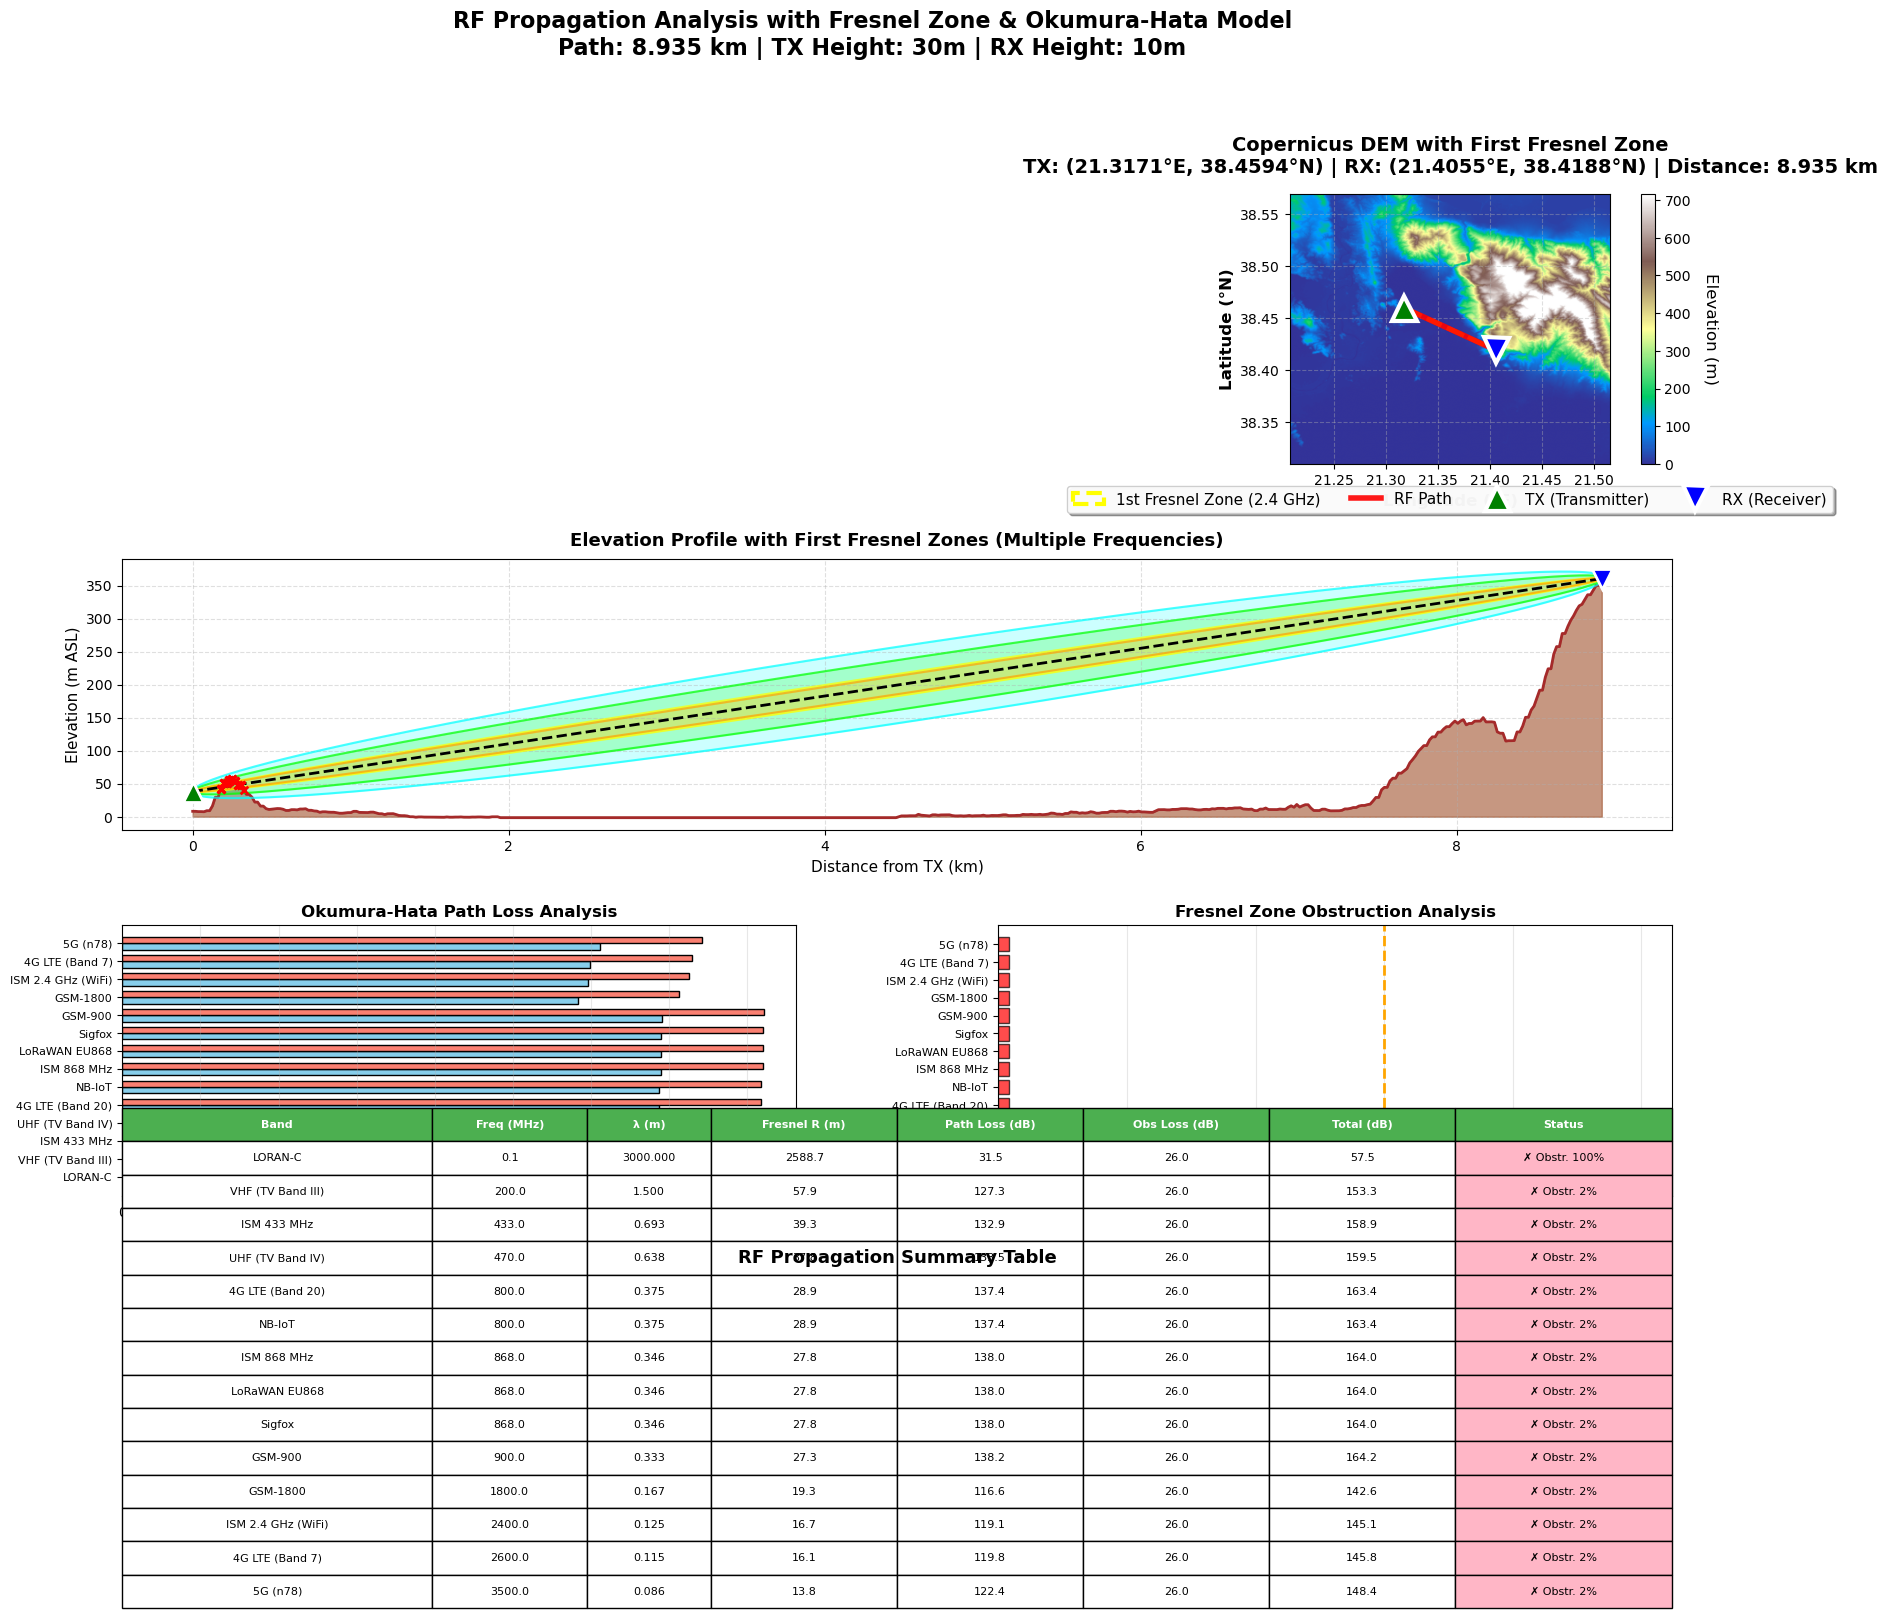


[Step 6/6] Exporting results to CSV...
✓ Propagation analysis: rf_propagation_analysis.csv
✓ Elevation profile: elevation_profile_data.csv

✓ COMPLETE! RF Propagation Analysis Finished
📁 DEM Raster:       copernicus_dem_30m.tif
📊 Visualization:    rf_propagation_analysis_complete.png
📈 Propagation Data: rf_propagation_analysis.csv
📍 Profile Data:     elevation_profile_data.csv


In [3]:
"""
COMPLETE SOLUTION: Copernicus DEM + Fresnel Zone Analysis + RF Propagation
Includes Okumura-Hata path loss prediction for multiple frequency bands
"""

import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import requests
from pathlib import Path
from matplotlib.patches import Ellipse
from matplotlib.patches import Polygon as MplPolygon
import pandas as pd

# --- 1. Define Points and Bounding Box ---
point1 = (21.31708, 38.45942)  # (lon, lat) Transmitter
point2 = (21.40549, 38.41883)  # (lon, lat) Receiver

# Expand bbox for context
buffer = 0.11
min_lon = min(point1[0], point2[0]) - buffer
max_lon = max(point1[0], point2[0]) + buffer
min_lat = min(point1[1], point2[1]) - buffer
max_lat = max(point1[1], point2[1]) + buffer

bbox = [min_lon, min_lat, max_lon, max_lat]
print("="*70)
print(f"RF PROPAGATION ANALYSIS WITH FRESNEL ZONE CLEARANCE")
print("="*70)
print(f"Transmitter: ({point1[0]:.5f}°E, {point1[1]:.5f}°N)")
print(f"Receiver:    ({point2[0]:.5f}°E, {point2[1]:.5f}°N)")
print(f"Area: ~{(max_lon-min_lon)*111:.1f} km × {(max_lat-min_lat)*111:.1f} km")
print("="*70)

# --- 2. Download Copernicus DEM tiles from AWS S3 ---
print("\n[Step 1/6] Downloading Copernicus DEM tiles...")

lon_tiles = range(int(np.floor(min_lon)), int(np.ceil(max_lon)))
lat_tiles = range(int(np.floor(min_lat)), int(np.ceil(max_lat)))

output_dir = Path("dem_tiles")
output_dir.mkdir(exist_ok=True)

downloaded_files = []

for lat in lat_tiles:
    for lon in lon_tiles:
        ns = 'N' if lat >= 0 else 'S'
        ew = 'E' if lon >= 0 else 'W'
        
        tile_name = f"Copernicus_DSM_COG_10_{ns}{abs(lat):02d}_00_{ew}{abs(lon):03d}_00_DEM"
        output_file = output_dir / f"{tile_name}.tif"
        
        if output_file.exists() and output_file.stat().st_size > 1000:
            print(f"  ✓ {tile_name} (cached)")
            downloaded_files.append(str(output_file))
            continue
        
        url = f"https://copernicus-dem-30m.s3.amazonaws.com/{tile_name}/{tile_name}.tif"
        
        try:
            print(f"  ⬇ {tile_name}...", end=" ", flush=True)
            response = requests.get(url, timeout=60)
            
            if response.status_code == 200:
                with open(output_file, 'wb') as f:
                    f.write(response.content)
                downloaded_files.append(str(output_file))
                print(f"✓ ({len(response.content)/1024/1024:.1f} MB)")
            else:
                print(f"✗ (HTTP {response.status_code})")
        except Exception as e:
            print(f"✗ Error: {e}")

if not downloaded_files:
    print("\n✗ ERROR: Could not download DEM tiles!")
    exit()

print(f"\n✓ Downloaded {len(downloaded_files)} tile(s)")

# --- 3. Merge Tiles ---
print("\n[Step 2/6] Merging DEM tiles...")

output_mosaic = "copernicus_dem_30m.tif"

try:
    src_files = [rasterio.open(f) for f in downloaded_files]
    mosaic, out_transform = merge(src_files, bounds=bbox)
    
    out_meta = src_files[0].meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_transform,
        "compress": "lzw"
    })
    
    with rasterio.open(output_mosaic, "w", **out_meta) as dest:
        dest.write(mosaic)
    
    for src in src_files:
        src.close()
    
    print(f"✓ Merged DEM: {output_mosaic}")
except Exception as e:
    print(f"Merge failed: {e}")
    if downloaded_files:
        output_mosaic = downloaded_files[0]

# --- 4. Extract Elevation Profile ---
print("\n[Step 3/6] Extracting elevation profile...")

def generate_line(p1, p2, num_points=500):
    lons = np.linspace(p1[0], p2[0], num_points)
    lats = np.linspace(p1[1], p2[1], num_points)
    return list(zip(lons, lats))

profile_line = generate_line(point1, point2, num_points=500)

# Calculate distance
dx = (point2[0] - point1[0]) * 111320 * np.cos(np.radians((point1[1] + point2[1]) / 2))
dy = (point2[1] - point1[1]) * 111320
total_distance = np.sqrt(dx**2 + dy**2)

print(f"  Path length: {total_distance/1000:.3f} km")

elevations = []
distances = []
coords = []

with rasterio.open(output_mosaic) as src:
    dem_data = src.read(1, masked=True)
    
    for i, (lon, lat) in enumerate(profile_line):
        try:
            row, col = src.index(lon, lat)
            if 0 <= row < src.height and 0 <= col < src.width:
                elev = dem_data[row, col]
                if elev is not np.ma.masked and not np.isnan(elev):
                    elevations.append(float(elev))
                    distances.append(i * total_distance / len(profile_line))
                    coords.append((lon, lat))
                else:
                    elevations.append(np.nan)
                    distances.append(i * total_distance / len(profile_line))
                    coords.append((lon, lat))
            else:
                elevations.append(np.nan)
                distances.append(i * total_distance / len(profile_line))
                coords.append((lon, lat))
        except:
            elevations.append(np.nan)
            distances.append(i * total_distance / len(profile_line))
            coords.append((lon, lat))

elevations = np.array(elevations)
distances = np.array(distances)

valid_mask = ~np.isnan(elevations)
valid_elevations = elevations[valid_mask]
valid_distances = distances[valid_mask]

print(f"✓ Extracted {len(valid_elevations)} valid points")

# --- 5. Fresnel Zone & RF Propagation Calculations ---
print("\n[Step 4/6] Calculating Fresnel zones and RF propagation...")

# Define frequency bands for analysis
freq_bands = {
    'VHF (TV Band III)': 200e6,      # 200 MHz
    'UHF (TV Band IV)': 470e6,        # 470 MHz
    'GSM-900': 900e6,                 # 900 MHz
    'GSM-1800': 1800e6,               # 1.8 GHz
    'LORAN-C': 100e3,                 # 100 kHz
    '4G LTE (Band 20)': 800e6,        # 800 MHz
    '4G LTE (Band 7)': 2600e6,        # 2.6 GHz
    '5G (n78)': 3500e6,               # 3.5 GHz
    'ISM 433 MHz': 433e6,             # 433 MHz
    'ISM 868 MHz': 868e6,             # 868 MHz
    'ISM 2.4 GHz (WiFi)': 2400e6,     # 2.4 GHz
    'LoRaWAN EU868': 868e6,           # 868 MHz
    'Sigfox': 868e6,                  # 868 MHz
    'NB-IoT': 800e6                   # 800 MHz
}

def fresnel_radius(d1, d2, f, n=1):
    """
    Calculate Fresnel zone radius
    d1, d2: distances from endpoints (meters)
    f: frequency (Hz)
    n: zone number (1 for first Fresnel zone)
    """
    c = 3e8  # speed of light
    wavelength = c / f
    return np.sqrt(n * wavelength * d1 * d2 / (d1 + d2))

def okumura_hata_urban(f_mhz, d_km, h_tx, h_rx):
    """
    Okumura-Hata model for urban areas
    f_mhz: frequency in MHz
    d_km: distance in km
    h_tx: transmitter height in meters
    h_rx: receiver height in meters
    Returns: path loss in dB
    """
    # Correction factor for mobile antenna height
    a_hm = (1.1 * np.log10(f_mhz) - 0.7) * h_rx - (1.56 * np.log10(f_mhz) - 0.8)
    
    # Path loss formula
    L = 69.55 + 26.16 * np.log10(f_mhz) - 13.82 * np.log10(h_tx) - a_hm + \
        (44.9 - 6.55 * np.log10(h_tx)) * np.log10(d_km)
    
    return L

# Antenna heights (adjustable)
h_tx = 30  # transmitter height above ground (meters)
h_rx = 10  # receiver height above ground (meters)

# Get transmitter and receiver elevations
tx_elev = valid_elevations[0]
rx_elev = valid_elevations[-1]

print(f"  Transmitter elevation: {tx_elev:.1f}m + {h_tx}m antenna = {tx_elev + h_tx:.1f}m ASL")
print(f"  Receiver elevation: {rx_elev:.1f}m + {h_rx}m antenna = {rx_elev + h_rx:.1f}m ASL")

# Calculate Fresnel zones and obstructions for each frequency
results = {}

for band_name, freq in freq_bands.items():
    wavelength = 3e8 / freq
    
    # Calculate first Fresnel zone radius at midpoint
    d_mid = total_distance / 2
    r_max = fresnel_radius(d_mid, d_mid, freq, n=1)
    
    # Calculate line-of-sight elevation profile
    los_elevations = np.linspace(tx_elev + h_tx, rx_elev + h_rx, len(valid_distances))
    
    # Calculate Fresnel zone boundary (ellipsoid cross-section)
    fresnel_upper = []
    fresnel_lower = []
    obstructed_points = []
    
    for i, d in enumerate(valid_distances):
        d1 = d
        d2 = total_distance - d
        
        if d1 > 0 and d2 > 0:
            r = fresnel_radius(d1, d2, freq, n=1)
            
            # LOS height at this point
            los_height = los_elevations[i]
            
            fresnel_upper.append(los_height + r)
            fresnel_lower.append(los_height - r)
            
            # Check if terrain obstructs Fresnel zone
            terrain_height = valid_elevations[i]
            if terrain_height > los_height - 0.6 * r:  # 60% Fresnel clearance criterion
                obstructed_points.append(i)
        else:
            fresnel_upper.append(los_elevations[i])
            fresnel_lower.append(los_elevations[i])
    
    fresnel_upper = np.array(fresnel_upper)
    fresnel_lower = np.array(fresnel_lower)
    
    # Calculate obstruction metrics
    clearance_ok = len(obstructed_points) == 0
    obstruction_pct = 100 * len(obstructed_points) / len(valid_distances)
    
    # Okumura-Hata path loss
    d_km = total_distance / 1000
    f_mhz = freq / 1e6
    
    if f_mhz >= 150 and f_mhz <= 1500:  # Valid range for Okumura-Hata
        path_loss = okumura_hata_urban(f_mhz, d_km, h_tx, h_rx)
    else:
        # Free space path loss for frequencies outside Okumura-Hata range
        path_loss = 32.45 + 20 * np.log10(f_mhz) + 20 * np.log10(d_km)
    
    # Additional loss due to obstruction
    if not clearance_ok:
        diffraction_loss = 6 + 20  # Approximate additional loss for obstruction
        total_loss = path_loss + diffraction_loss
    else:
        total_loss = path_loss
        diffraction_loss = 0
    
    results[band_name] = {
        'frequency': freq,
        'wavelength': wavelength,
        'max_radius': r_max,
        'fresnel_upper': fresnel_upper,
        'fresnel_lower': fresnel_lower,
        'obstructed_points': obstructed_points,
        'clearance_ok': clearance_ok,
        'obstruction_pct': obstruction_pct,
        'path_loss': path_loss,
        'diffraction_loss': diffraction_loss,
        'total_loss': total_loss,
        'los_elevations': los_elevations
    }
    
    status = "✓ CLEAR" if clearance_ok else f"✗ OBSTRUCTED ({obstruction_pct:.1f}%)"
    print(f"  {band_name:20s} | {freq/1e6:8.1f} MHz | Fresnel: {r_max:5.1f}m | {status}")

# --- 6. Create Comprehensive Visualization ---
print("\n[Step 5/6] Creating visualizations...")

# Create figure with custom layout
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 2, height_ratios=[2, 2, 2, 1], hspace=0.4, wspace=0.3)

# ========== PLOT 1: DEM Map with Fresnel Zone (TOP, FULL WIDTH, LARGE) ==========
ax1 = fig.add_subplot(gs[0, :])

with rasterio.open(output_mosaic) as src:
    dem_display = src.read(1, masked=True)
    vmin = np.percentile(dem_display.compressed(), 2)
    vmax = np.percentile(dem_display.compressed(), 98)
    
    im = show(src, ax=ax1, cmap="terrain", vmin=vmin, vmax=vmax)
    
    # Add colorbar
    cbar = plt.colorbar(im.images[0], ax=ax1, fraction=0.02, pad=0.02)
    cbar.set_label('Elevation (m)', rotation=270, labelpad=20, fontsize=12)
    
    # Draw Fresnel zone ellipse (use 2.4 GHz WiFi as reference)
    wifi_results = results['ISM 2.4 GHz (WiFi)']
    
    # Calculate ellipse parameters
    center_lon = (point1[0] + point2[0]) / 2
    center_lat = (point1[1] + point2[1]) / 2
    
    # Semi-major axis (path distance)
    a_deg = np.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2) / 2
    
    # Semi-minor axis (max Fresnel radius converted to degrees)
    b_deg = wifi_results['max_radius'] / 111320  # Convert meters to degrees
    
    # Angle of major axis
    angle = np.degrees(np.arctan2(point2[1] - point1[1], point2[0] - point1[0]))
    
    # Draw ellipse
    ellipse = Ellipse((center_lon, center_lat), width=2*a_deg, height=2*b_deg,
                     angle=angle, fill=False, edgecolor='yellow', linewidth=3,
                     linestyle='--', label='1st Fresnel Zone (2.4 GHz)', zorder=8)
    ax1.add_patch(ellipse)
    
    # Overlay profile line
    ax1.plot([point1[0], point2[0]], [point1[1], point2[1]], 
             'r-', linewidth=4, label='RF Path', alpha=0.9, zorder=10)
    ax1.plot(point1[0], point1[1], 'g^', markersize=18, 
             label='TX (Transmitter)', zorder=15, markeredgecolor='white', markeredgewidth=3)
    ax1.plot(point2[0], point2[1], 'bv', markersize=18, 
             label='RX (Receiver)', zorder=15, markeredgecolor='white', markeredgewidth=3)

ax1.set_title(f"Copernicus DEM with First Fresnel Zone\n" +
              f"TX: ({point1[0]:.4f}°E, {point1[1]:.4f}°N) | " +
              f"RX: ({point2[0]:.4f}°E, {point2[1]:.4f}°N) | " +
              f"Distance: {total_distance/1000:.3f} km", 
              fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel("Longitude (°E)", fontsize=12, fontweight='bold')
ax1.set_ylabel("Latitude (°N)", fontsize=12, fontweight='bold')

# Legend at top center
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), 
          ncol=4, fontsize=11, framealpha=0.95, shadow=True)
ax1.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)

# ========== PLOT 2: Elevation Profile with Multiple Fresnel Zones ==========
ax2 = fig.add_subplot(gs[1, :])

# Plot terrain
ax2.fill_between(valid_distances/1000, 0, valid_elevations, 
                 alpha=0.6, color='sienna', label='Terrain')
ax2.plot(valid_distances/1000, valid_elevations, 
         linewidth=2, color='brown', label='Ground Elevation')

# Plot line of sight
los_line = results['ISM 2.4 GHz (WiFi)']['los_elevations']
ax2.plot(valid_distances/1000, los_line, 
         'k--', linewidth=2, label='Line of Sight', zorder=5)

# Plot Fresnel zones for selected frequencies
colors = ['cyan', 'lime', 'yellow', 'orange']
selected_freqs = ['VHF (TV Band III)', 'UHF (TV Band IV)', 'ISM 2.4 GHz (WiFi)', '5G (n78)']

for i, band in enumerate(selected_freqs):
    res = results[band]
    color = colors[i]
    
    # Draw Fresnel zone
    ax2.fill_between(valid_distances/1000, res['fresnel_lower'], res['fresnel_upper'],
                     alpha=0.2, color=color, label=f"{band} ({res['frequency']/1e6:.0f} MHz)")
    ax2.plot(valid_distances/1000, res['fresnel_upper'], 
             color=color, linewidth=1.5, linestyle='-', alpha=0.7)
    ax2.plot(valid_distances/1000, res['fresnel_lower'], 
             color=color, linewidth=1.5, linestyle='-', alpha=0.7)
    
    # Highlight obstructed points
    if res['obstructed_points']:
        obs_dist = valid_distances[res['obstructed_points']] / 1000
        obs_elev = valid_elevations[res['obstructed_points']]
        ax2.scatter(obs_dist, obs_elev, color='red', s=30, 
                   marker='x', linewidths=2, zorder=10)

# Mark TX and RX
ax2.plot(0, tx_elev + h_tx, 'g^', markersize=15, 
         markeredgecolor='white', markeredgewidth=2, zorder=20, label='TX Antenna')
ax2.plot(valid_distances[-1]/1000, rx_elev + h_rx, 'bv', markersize=15,
         markeredgecolor='white', markeredgewidth=2, zorder=20, label='RX Antenna')

ax2.set_title("Elevation Profile with First Fresnel Zones (Multiple Frequencies)", 
              fontsize=13, fontweight='bold', pad=10)
ax2.set_xlabel("Distance from TX (km)", fontsize=11)
ax2.set_ylabel("Elevation (m ASL)", fontsize=11)
ax2.grid(True, alpha=0.4, linestyle='--')
ax2.legend(loc='upper right', bbox_to_anchor=(0.5, -1.5), fontsize=9, framealpha=0.95, ncol=2)

# ========== PLOT 3: Path Loss Comparison ==========
ax3 = fig.add_subplot(gs[2, 0])

bands_sorted = sorted(results.items(), key=lambda x: x[1]['frequency'])
band_names = [b[0] for b in bands_sorted]
path_losses = [b[1]['path_loss'] for b in bands_sorted]
total_losses = [b[1]['total_loss'] for b in bands_sorted]

x_pos = np.arange(len(band_names))
width = 0.35

bars1 = ax3.barh(x_pos - width/2, path_losses, width, 
                 label='Okumura-Hata Path Loss', color='skyblue', edgecolor='black')
bars2 = ax3.barh(x_pos + width/2, total_losses, width,
                 label='Total Loss (with obstruction)', color='salmon', edgecolor='black')

ax3.set_yticks(x_pos)
ax3.set_yticklabels(band_names, fontsize=8)
ax3.set_xlabel('Path Loss (dB)', fontsize=10)
ax3.set_title('Okumura-Hata Path Loss Analysis', fontsize=12, fontweight='bold')
ax3.legend(loc='lower right', fontsize=9)
ax3.grid(True, alpha=0.3, axis='x')

# ========== PLOT 4: Clearance Status ==========
ax4 = fig.add_subplot(gs[2, 1])

clearance_status = [1 if b[1]['clearance_ok'] else 0 for b in bands_sorted]
obstruction_pcts = [b[1]['obstruction_pct'] for b in bands_sorted]

colors_status = ['green' if s else 'red' for s in clearance_status]

bars = ax4.barh(x_pos, obstruction_pcts, color=colors_status, edgecolor='black', alpha=0.7)

ax4.set_yticks(x_pos)
ax4.set_yticklabels(band_names, fontsize=8)
ax4.set_xlabel('Obstruction (%)', fontsize=10)
ax4.set_title('Fresnel Zone Obstruction Analysis', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')
ax4.axvline(60, color='orange', linestyle='--', linewidth=2, label='60% threshold')
ax4.legend(loc='lower right', fontsize=9)

# ========== PLOT 5: Summary Table ==========
ax5 = fig.add_subplot(gs[3, :])
ax5.axis('off')

# Create summary table
table_data = []
table_data.append(['Band', 'Freq (MHz)', 'λ (m)', 'Fresnel R (m)', 
                  'Path Loss (dB)', 'Obs Loss (dB)', 'Total (dB)', 'Status'])

for band, res in sorted(results.items(), key=lambda x: x[1]['frequency']):
    status = '✓ Clear' if res['clearance_ok'] else f"✗ Obstr. {res['obstruction_pct']:.0f}%"
    table_data.append([
        band,
        f"{res['frequency']/1e6:.1f}",
        f"{res['wavelength']:.3f}",
        f"{res['max_radius']:.1f}",
        f"{res['path_loss']:.1f}",
        f"{res['diffraction_loss']:.1f}",
        f"{res['total_loss']:.1f}",
        status
    ])

table = ax5.table(cellText=table_data, cellLoc='center', loc='center',
                 colWidths=[0.2, 0.1, 0.08, 0.12, 0.12, 0.12, 0.12, 0.14])
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 2)

# Style header row
for i in range(len(table_data[0])):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color code status column
for i in range(1, len(table_data)):
    if '✓' in table_data[i][-1]:
        table[(i, 7)].set_facecolor('#90EE90')
    else:
        table[(i, 7)].set_facecolor('#FFB6C6')

ax5.set_title('RF Propagation Summary Table', 
             fontsize=13, fontweight='bold', pad=20)

# Overall title
fig.suptitle(f'RF Propagation Analysis with Fresnel Zone & Okumura-Hata Model\n' +
            f'Path: {total_distance/1000:.3f} km | TX Height: {h_tx}m | RX Height: {h_rx}m', 
            fontsize=16, fontweight='bold', y=0.995)

# Save
output_plot = "rf_propagation_analysis_complete.png"
plt.savefig(output_plot, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Visualization saved: {output_plot}")

plt.show()

# --- 7. Export Detailed Results ---
print("\n[Step 6/6] Exporting results to CSV...")

# Export propagation analysis
prop_df = pd.DataFrame([{
    'Band': band,
    'Frequency_MHz': res['frequency'] / 1e6,
    'Wavelength_m': res['wavelength'],
    'Max_Fresnel_Radius_m': res['max_radius'],
    'Path_Loss_dB': res['path_loss'],
    'Diffraction_Loss_dB': res['diffraction_loss'],
    'Total_Loss_dB': res['total_loss'],
    'Clearance_OK': res['clearance_ok'],
    'Obstruction_Percent': res['obstruction_pct']
} for band, res in results.items()])

prop_csv = "rf_propagation_analysis.csv"
prop_df.to_csv(prop_csv, index=False, float_format='%.3f')

print(f"✓ Propagation analysis: {prop_csv}")

# Export elevation profile
profile_df = pd.DataFrame({
    'Distance_km': valid_distances / 1000,
    'Elevation_m': valid_elevations,
    'Longitude': [coords[i][0] for i in range(len(valid_distances)) if valid_mask[i]],
    'Latitude': [coords[i][1] for i in range(len(valid_distances)) if valid_mask[i]]
})

profile_csv = "elevation_profile_data.csv"
profile_df.to_csv(profile_csv, index=False, float_format='%.6f')

print(f"✓ Elevation profile: {profile_csv}")

print("\n" + "="*70)
print("✓ COMPLETE! RF Propagation Analysis Finished")
print("="*70)
print(f"📁 DEM Raster:       {output_mosaic}")
print(f"📊 Visualization:    {output_plot}")
print(f"📈 Propagation Data: {prop_csv}")
print(f"📍 Profile Data:     {profile_csv}")
print("="*70)

RF PROPAGATION ANALYSIS WITH FRESNEL ZONE CLEARANCE
Transmitter: (21.31708°E, 38.45942°N)
Receiver:    (21.40549°E, 38.41883°N)
Area: ~65.3 km × 60.0 km

[Step 1/6] Downloading Copernicus DEM tiles (10m resolution, GLO-30)...
  ✓ Copernicus_DSM_COG_10_N38_00_E021_00_DEM (cached)

✓ Downloaded 1 tile(s)

[Step 2/6] Merging DEM tiles...
✓ Merged DEM saved as: copernicus_dem_30m.tif

[Step 3/6] Extracting elevation profile...
  Path length: 8.935 km
✓ Extracted 1000 valid points

[Step 4/6] Calculating Fresnel zones and RF propagation...
  Transmitter elevation: 8.2m + 30m antenna = 38.2m ASL
  Receiver elevation: 350.5m + 10m antenna = 360.5m ASL
  VHF (TV Band III)    |    200.0 MHz | Fresnel R1:  57.9m | ✗ OBSTRUCTED (1.9%)
  UHF (TV Band IV)     |    470.0 MHz | Fresnel R1:  37.8m | ✗ OBSTRUCTED (1.6%)
  GSM-900              |    900.0 MHz | Fresnel R1:  27.3m | ✗ OBSTRUCTED (1.5%)
  GSM-1800             |   1800.0 MHz | Fresnel R1:  19.3m | ✗ OBSTRUCTED (1.5%)
  4G LTE (Band 20)     

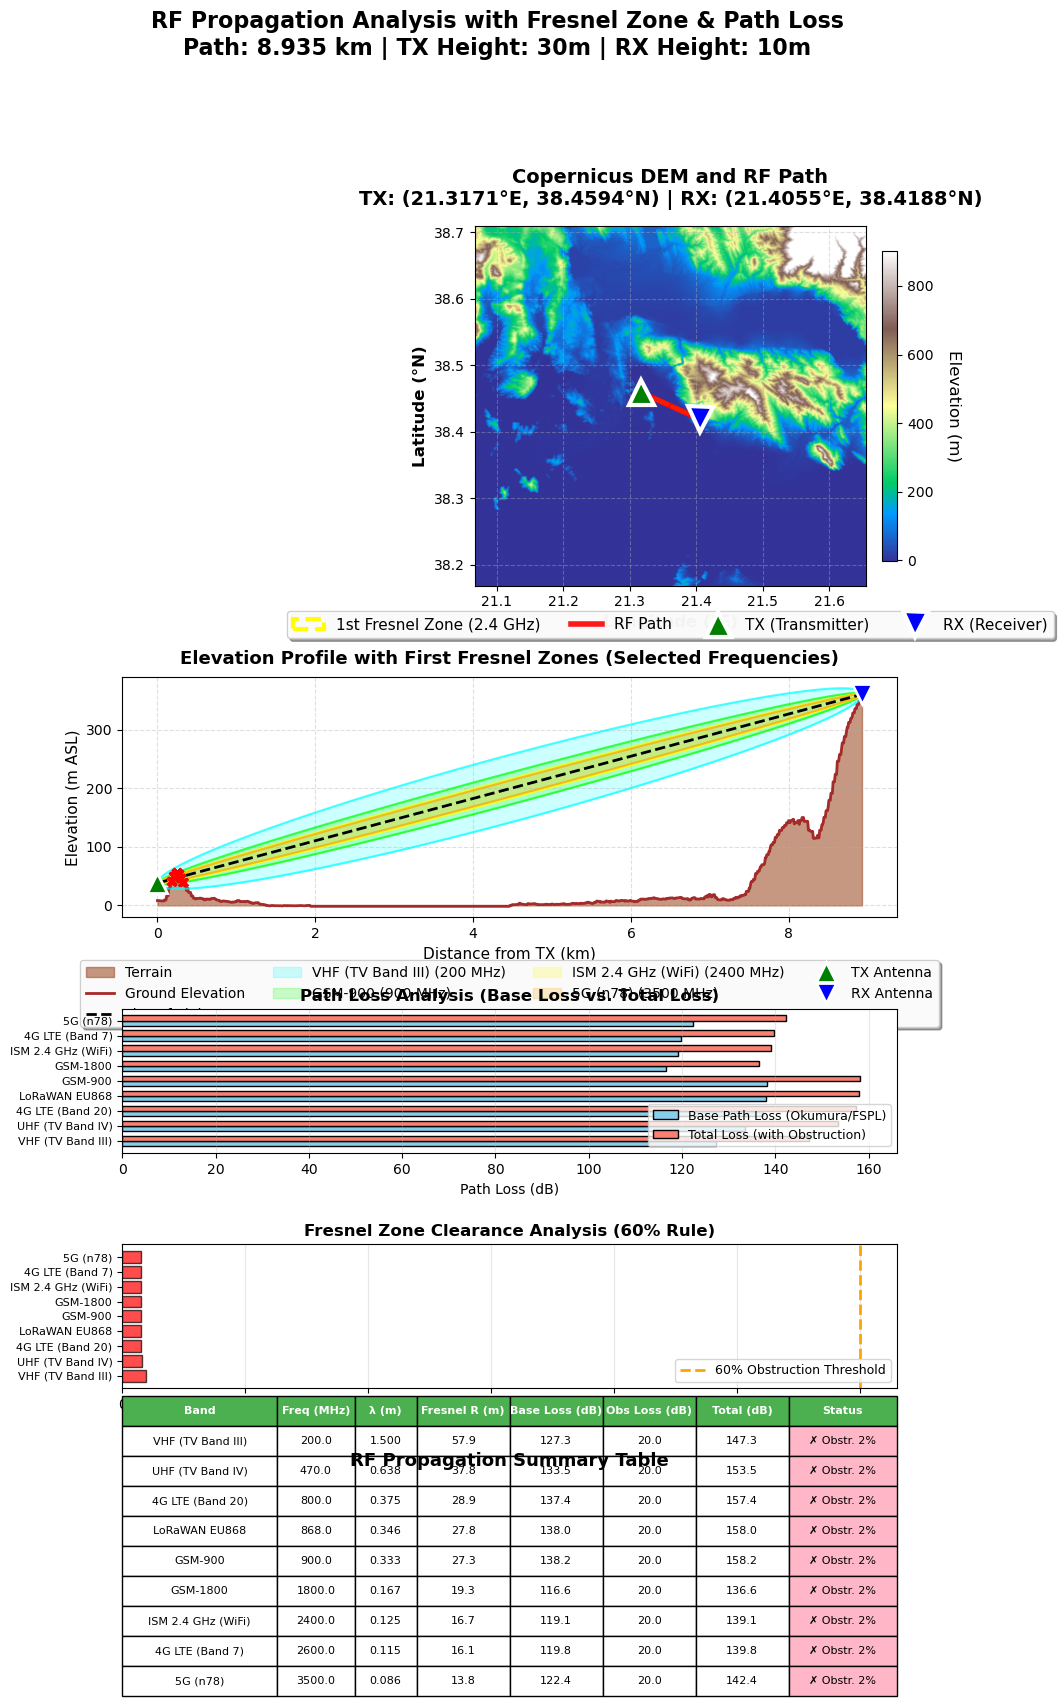


[Step 6/6] Exporting results to CSV...
✓ Propagation analysis: rf_propagation_analysis.csv
✓ Elevation profile: elevation_profile_data.csv

✓ COMPLETE! RF Propagation Analysis Finished
📁 DEM Raster:      copernicus_dem_30m.tif
📊 Visualization:   rf_propagation_analysis_complete.png
📈 Propagation Data: rf_propagation_analysis.csv
📍 Profile Data:    elevation_profile_data.csv


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import requests
from pathlib import Path
from matplotlib.patches import Ellipse
import pandas as pd
import os # Import os for environment control

# --- 1. Define Points and Bounding Box ---
# Define the coordinates for the Transmitter (TX) and Receiver (RX)
point1 = (21.31708, 38.45942)  # (lon, lat) Transmitter (TX)
point2 = (21.40549, 38.41883)  # (lon, lat) Receiver (RX)

# Expand the bounding box (bbox) for better visual context and a longer path profile
# Increasing this buffer value increases the total distance and the area of the DEM.
buffer = 0.25 
min_lon = min(point1[0], point2[0]) - buffer
max_lon = max(point1[0], point2[0]) + buffer
min_lat = min(point1[1], point2[1]) - buffer
max_lat = max(point1[1], point2[1]) + buffer

bbox = [min_lon, min_lat, max_lon, max_lat]
print("="*70)
print(f"RF PROPAGATION ANALYSIS WITH FRESNEL ZONE CLEARANCE")
print("="*70)
print(f"Transmitter: ({point1[0]:.5f}°E, {point1[1]:.5f}°N)")
print(f"Receiver:    ({point2[0]:.5f}°E, {point2[1]:.5f}°N)")
# Approximate the size of the area in kilometers (1 degree latitude ≈ 111 km)
print(f"Area: ~{(max_lon-min_lon)*111:.1f} km × {(max_lat-min_lat)*111:.1f} km")
print("="*70)

# --- 2. Download Copernicus DEM tiles from AWS S3 (GLO-30) ---
print("\n[Step 1/6] Downloading Copernicus DEM tiles (10m resolution, GLO-30)...")

# Determine which 1x1 degree tiles are needed based on the expanded bbox
lon_tiles = range(int(np.floor(min_lon)), int(np.ceil(max_lon)))
lat_tiles = range(int(np.floor(min_lat)), int(np.ceil(max_lat)))

output_dir = Path("dem_tiles")
output_dir.mkdir(exist_ok=True) # Create a directory to store downloaded tiles

downloaded_files = []

# Iterate through the required 1x1 degree grid cells
for lat in lat_tiles:
    for lon in lon_tiles:
        ns = 'N' if lat >= 0 else 'S' # Determine North or South
        ew = 'E' if lon >= 0 else 'W' # Determine East or West
        
        # Construct the tile name format used by Copernicus DEM GLO-30 (10m)
        tile_name = f"Copernicus_DSM_COG_10_{ns}{abs(lat):02d}_00_{ew}{abs(lon):03d}_00_DEM"
        output_file = output_dir / f"{tile_name}.tif"
        
        # Check if file is already downloaded and is a reasonable size (>1kb)
        if output_file.exists() and output_file.stat().st_size > 1000:
            print(f"  ✓ {tile_name} (cached)")
            downloaded_files.append(str(output_file))
            continue
        
        # AWS S3 public bucket URL for Copernicus DEM 30m
        url = f"https://copernicus-dem-30m.s3.amazonaws.com/{tile_name}/{tile_name}.tif"
        
        try:
            print(f"  ⬇ {tile_name}...", end=" ", flush=True)
            response = requests.get(url, timeout=60)
            
            if response.status_code == 200:
                with open(output_file, 'wb') as f:
                    f.write(response.content)
                downloaded_files.append(str(output_file))
                print(f"✓ ({len(response.content)/1024/1024:.1f} MB)")
            else:
                print(f"✗ (HTTP {response.status_code})")
        except Exception as e:
            print(f"✗ Error: {e}")

if not downloaded_files:
    print("\n✗ ERROR: Could not download DEM tiles! Check connectivity or coordinates.")
    exit()

print(f"\n✓ Downloaded {len(downloaded_files)} tile(s)")

# --- 3. Merge Tiles ---
print("\n[Step 2/6] Merging DEM tiles...")

output_mosaic = "copernicus_dem_30m.tif"

try:
    # Open all downloaded files with rasterio
    src_files = [rasterio.open(f) for f in downloaded_files]
    # Merge them into a single mosaic array, cropped to the specified bbox
    mosaic, out_transform = merge(src_files, bounds=bbox)
    
    # Update the metadata for the output file
    out_meta = src_files[0].meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_transform,
        "compress": "lzw" # Use LZW compression for smaller file size
    })
    
    # Write the merged mosaic to the output file
    with rasterio.open(output_mosaic, "w", **out_meta) as dest:
        dest.write(mosaic)
    
    # Close all source files
    for src in src_files:
        src.close()
    
    print(f"✓ Merged DEM saved as: {output_mosaic}")
except Exception as e:
    print(f"Merge failed: {e}")
    # Fallback: if merge fails, use the first tile (useful for single tile cases)
    if downloaded_files:
        output_mosaic = downloaded_files[0]
        print(f"Using single tile as fallback: {output_mosaic}")

# --- 4. Extract Elevation Profile ---
print("\n[Step 3/6] Extracting elevation profile...")

def generate_line(p1, p2, num_points=1000): # Increased points for smoother profile
    """Generates a list of (lon, lat) points evenly spaced between p1 and p2."""
    lons = np.linspace(p1[0], p2[0], num_points)
    lats = np.linspace(p1[1], p2[1], num_points)
    return list(zip(lons, lats))

profile_line = generate_line(point1, point2, num_points=1000)

# Calculate geodetic distance in meters using an approximation (valid for small areas)
# 1 degree of latitude is ~111320 meters. 1 degree of longitude depends on latitude.
dx = (point2[0] - point1[0]) * 111320 * np.cos(np.radians((point1[1] + point2[1]) / 2))
dy = (point2[1] - point1[1]) * 111320
total_distance = np.sqrt(dx**2 + dy**2)

print(f"  Path length: {total_distance/1000:.3f} km")

elevations = []
distances = []
coords = [] # Stores (lon, lat) for valid points

with rasterio.open(output_mosaic) as src:
    # Read the data using a masked array (automatically handles NoData)
    dem_data = src.read(1, masked=True)
    
    for i, (lon, lat) in enumerate(profile_line):
        try:
            # Convert lon, lat to pixel row, col index
            row, col = src.index(lon, lat)
            
            # Check if the index is within the raster boundaries
            if 0 <= row < src.height and 0 <= col < src.width:
                elev = dem_data[row, col]
                
                # Check if the value is valid (not masked/NoData)
                if elev is not np.ma.masked:
                    elevations.append(float(elev))
                    # Calculate cumulative distance along the path
                    distances.append(i * total_distance / len(profile_line))
                    coords.append((lon, lat))
                # Skip NoData points
            # Skip out-of-bounds points (shouldn't happen with the bbox)
        except Exception:
            # Handle any indexing error (should be rare)
            pass

elevations = np.array(elevations)
distances = np.array(distances)

# Filter for only the valid, non-NaN elevation points
valid_mask = ~np.isnan(elevations)
valid_elevations = elevations
valid_distances = distances

# Re-filter valid points after the initial pass
valid_elevations = valid_elevations[~np.isnan(valid_elevations)]
valid_distances = valid_distances[~np.isnan(elevations)]


print(f"✓ Extracted {len(valid_elevations)} valid points")

# --- 5. Fresnel Zone & RF Propagation Calculations ---
print("\n[Step 4/6] Calculating Fresnel zones and RF propagation...")

# Define standard antenna heights (can be changed)
h_tx = 30  # transmitter height above ground (meters)
h_rx = 10  # receiver height above ground (meters)

# Define common frequency bands for analysis
freq_bands = {
    'VHF (TV Band III)': 200e6,      # 200 MHz
    'UHF (TV Band IV)': 470e6,       # 470 MHz
    'GSM-900': 900e6,                # 900 MHz (2G)
    'GSM-1800': 1800e6,              # 1.8 GHz (2G/4G)
    '4G LTE (Band 20)': 800e6,       # 800 MHz
    '4G LTE (Band 7)': 2600e6,       # 2.6 GHz
    '5G (n78)': 3500e6,              # 3.5 GHz
    'ISM 2.4 GHz (WiFi)': 2400e6,    # 2.4 GHz (WiFi/Bluetooth)
    'LoRaWAN EU868': 868e6,          # 868 MHz (IoT)
}

def fresnel_radius(d1, d2, f, n=1):
    """
    Calculate the radius of the nth Fresnel zone (R_n).
    d1, d2: distances from endpoints to the point of interest (meters)
    f: frequency (Hz)
    n: zone number (1 for the first Fresnel zone)
    """
    c = 3e8  # speed of light
    wavelength = c / f
    return np.sqrt(n * wavelength * d1 * d2 / (d1 + d2))

def okumura_hata_urban(f_mhz, d_km, h_tx, h_rx):
    """
    Okumura-Hata empirical path loss model for urban areas.
    Valid for 150 MHz < f < 1500 MHz, 1 km < d < 20 km.
    """
    # Correction factor for mobile antenna height (a(h_m))
    a_hm = (1.1 * np.log10(f_mhz) - 0.7) * h_rx - (1.56 * np.log10(f_mhz) - 0.8)
    
    # Path loss formula (L_urban)
    L = 69.55 + 26.16 * np.log10(f_mhz) - 13.82 * np.log10(h_tx) - a_hm + \
        (44.9 - 6.55 * np.log10(h_tx)) * np.log10(d_km)
    
    return L

# Get transmitter and receiver elevations from the extracted profile
if not valid_elevations.size:
    print("FATAL ERROR: Profile extraction returned no valid points. Cannot continue.")
    exit()

tx_elev = valid_elevations[0]
rx_elev = valid_elevations[-1]

print(f"  Transmitter elevation: {tx_elev:.1f}m + {h_tx}m antenna = {tx_elev + h_tx:.1f}m ASL")
print(f"  Receiver elevation: {rx_elev:.1f}m + {h_rx}m antenna = {rx_elev + h_rx:.1f}m ASL")

# Calculate Fresnel zones and obstructions for each frequency
results = {}
d_km = total_distance / 1000 # Total path distance in km

for band_name, freq in freq_bands.items():
    wavelength = 3e8 / freq
    
    # Calculate first Fresnel zone radius (R1) at the midpoint for summary
    d_mid = total_distance / 2
    r_max = fresnel_radius(d_mid, d_mid, freq, n=1)
    
    # Calculate the Line-of-Sight (LOS) elevation profile (straight line between antenna tops)
    los_elevations = np.linspace(tx_elev + h_tx, rx_elev + h_rx, len(valid_distances))
    
    fresnel_upper = []
    fresnel_lower = []
    obstructed_points = []
    
    for i, d in enumerate(valid_distances):
        d1 = d # Distance from TX
        d2 = total_distance - d # Distance from RX
        
        if d1 > 0 and d2 > 0:
            # Calculate 1st Fresnel radius at this point
            r = fresnel_radius(d1, d2, freq, n=1)
            
            los_height = los_elevations[i]
            terrain_height = valid_elevations[i]
            
            fresnel_upper.append(los_height + r)
            fresnel_lower.append(los_height - r)
            
            # Check for obstruction: Clearance should be at least 60% of the first Fresnel radius (0.6*R1)
            if terrain_height > los_height - 0.6 * r:
                obstructed_points.append(i)
        else:
            # For the endpoints (d=0 or d=total_distance), set boundary to LOS height
            fresnel_upper.append(los_elevations[i])
            fresnel_lower.append(los_elevations[i])
            
    fresnel_upper = np.array(fresnel_upper)
    fresnel_lower = np.array(fresnel_lower)
    
    # Calculate obstruction metrics
    clearance_ok = len(obstructed_points) == 0
    obstruction_pct = 100 * len(obstructed_points) / len(valid_distances)
    
    # --- Path Loss Calculation ---
    f_mhz = freq / 1e6
    
    if 150 <= f_mhz <= 1500 and 1 <= d_km <= 20 and h_tx >= 30 and h_rx >= 1:
        # Use Okumura-Hata for valid range (Urban model used as default)
        path_loss = okumura_hata_urban(f_mhz, d_km, h_tx, h_rx)
    else:
        # Use Free Space Path Loss (FSPL) as a fallback for out-of-range frequencies/distances
        path_loss = 32.45 + 20 * np.log10(f_mhz) + 20 * np.log10(d_km)
    
    # Additional loss due to diffraction over obstructions
    diffraction_loss = 0
    if not clearance_ok:
        # Simple approximation: add a fixed penalty for obstruction (e.g., 20 dB)
        diffraction_loss = 20 
        total_loss = path_loss + diffraction_loss
    else:
        total_loss = path_loss
        
    results[band_name] = {
        'frequency': freq,
        'wavelength': wavelength,
        'max_radius': r_max,
        'fresnel_upper': fresnel_upper,
        'fresnel_lower': fresnel_lower,
        'obstructed_points': obstructed_points,
        'clearance_ok': clearance_ok,
        'obstruction_pct': obstruction_pct,
        'path_loss': path_loss,
        'diffraction_loss': diffraction_loss,
        'total_loss': total_loss,
        'los_elevations': los_elevations
    }
    
    status = "✓ CLEAR" if clearance_ok else f"✗ OBSTRUCTED ({obstruction_pct:.1f}%)"
    print(f"  {band_name:20s} | {f_mhz:8.1f} MHz | Fresnel R1: {r_max:5.1f}m | {status}")

# --- 6. Create Comprehensive Visualization (Plots & Table) ---
print("\n[Step 5/6] Creating visualizations...")

# Create figure with custom layout: 4 rows, 1 column, using gridspec for precise spacing
fig = plt.figure(figsize=(10, 18))
# Height ratios: 2.5 for the large map, then 1.5 for the profile, 1 for the two loss graphs, 1 for the table
gs = fig.add_gridspec(5, 1, height_ratios=[3, 2, 1.2, 1.2, 1.1], hspace=0.45, wspace=0.3) 

# Overall title for the entire figure
fig.suptitle(
    f'RF Propagation Analysis with Fresnel Zone & Path Loss\n' +
    f'Path: {total_distance/1000:.3f} km | TX Height: {h_tx}m | RX Height: {h_rx}m', 
    fontsize=16, fontweight='bold', y=1.0 # Move title up slightly
)

# =========================================================================
# ========== PLOT 1: DEM Map with Fresnel Zone (TOP) ==========
# =========================================================================
ax1 = fig.add_subplot(gs[0, 0])

with rasterio.open(output_mosaic) as src:
    dem_display = src.read(1, masked=True)
    # Define color scale min/max using percentiles to ignore extreme outliers
    vmin = np.percentile(dem_display.compressed(), 2)
    vmax = np.percentile(dem_display.compressed(), 98)
    
    im = show(src, ax=ax1, cmap="terrain", vmin=vmin, vmax=vmax)
    
    # Add colorbar
    cbar = plt.colorbar(im.images[0], ax=ax1, fraction=0.02, pad=0.02)
    cbar.set_label('Elevation (m)', rotation=270, labelpad=20, fontsize=12)
    
    # Draw Fresnel zone ellipse (use ISM 2.4 GHz WiFi as reference for the map)
    wifi_results = results['ISM 2.4 GHz (WiFi)']
    
    # Calculate ellipse parameters
    center_lon = (point1[0] + point2[0]) / 2
    center_lat = (point1[1] + point2[1]) / 2
    
    # Semi-major axis: half of the total path length in degrees
    a_deg = np.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2) / 2
    
    # Semi-minor axis: max Fresnel radius converted to degrees (approx. 111320 m/degree)
    b_deg = wifi_results['max_radius'] / 111320 
    
    # Angle of major axis (path direction)
    angle = np.degrees(np.arctan2(point2[1] - point1[1], point2[0] - point1[0]))
    
    # Draw ellipse
    ellipse = Ellipse((center_lon, center_lat), width=2*a_deg, height=2*b_deg,
                      angle=angle, fill=False, edgecolor='yellow', linewidth=3,
                      linestyle='--', label='1st Fresnel Zone (2.4 GHz)', zorder=8)
    ax1.add_patch(ellipse)
    
    # Overlay profile line and antenna markers
    ax1.plot([point1[0], point2[0]], [point1[1], point2[1]], 
             'r-', linewidth=4, label='RF Path', alpha=0.9, zorder=10)
    ax1.plot(point1[0], point1[1], 'g^', markersize=18, 
             label='TX (Transmitter)', zorder=15, markeredgecolor='white', markeredgewidth=3)
    ax1.plot(point2[0], point2[1], 'bv', markersize=18, 
             label='RX (Receiver)', zorder=15, markeredgecolor='white', markeredgewidth=3)

ax1.set_title(f"Copernicus DEM and RF Path\n" +
              f"TX: ({point1[0]:.4f}°E, {point1[1]:.4f}°N) | " +
              f"RX: ({point2[0]:.4f}°E, {point2[1]:.4f}°N)", 
              fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel("Longitude (°E)", fontsize=12, fontweight='bold')
ax1.set_ylabel("Latitude (°N)", fontsize=12, fontweight='bold')

# Legend at the bottom center (outside the plot)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), 
           ncol=4, fontsize=11, framealpha=0.95, shadow=True)
ax1.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)

# =========================================================================
# ========== PLOT 2: Elevation Profile with Fresnel Zones ==========
# =========================================================================
ax2 = fig.add_subplot(gs[1, 0])

# Plot terrain profile (filled area for clear visualization)
ax2.fill_between(valid_distances/1000, 0, valid_elevations, 
                 alpha=0.6, color='sienna', label='Terrain')
ax2.plot(valid_distances/1000, valid_elevations, 
         linewidth=2, color='brown', label='Ground Elevation')

# Plot Line of Sight (LOS) between antennas
los_line = results['ISM 2.4 GHz (WiFi)']['los_elevations']
ax2.plot(valid_distances/1000, los_line, 
         'k--', linewidth=2, label='Line of Sight', zorder=5)

# Plot Fresnel zones for a selection of frequencies
colors = ['cyan', 'lime', 'yellow', 'orange']
selected_freqs = ['VHF (TV Band III)', 'GSM-900', 'ISM 2.4 GHz (WiFi)', '5G (n78)']

for i, band in enumerate(selected_freqs):
    res = results[band]
    color = colors[i]
    
    # Draw Fresnel zone boundaries (fill_between creates the shaded area)
    ax2.fill_between(valid_distances/1000, res['fresnel_lower'], res['fresnel_upper'],
                     alpha=0.2, color=color, label=f"{band} ({res['frequency']/1e6:.0f} MHz)")
    # Plot the upper/lower boundary lines
    ax2.plot(valid_distances/1000, res['fresnel_upper'], 
             color=color, linewidth=1.5, linestyle='-', alpha=0.7)
    ax2.plot(valid_distances/1000, res['fresnel_lower'], 
             color=color, linewidth=1.5, linestyle='-', alpha=0.7)
    
    # Highlight points where the 60% Fresnel clearance is violated
    if res['obstructed_points']:
        obs_dist = valid_distances[res['obstructed_points']] / 1000
        obs_elev = valid_elevations[res['obstructed_points']]
        # Scatter plot marks the specific obstructed terrain points
        ax2.scatter(obs_dist, obs_elev, color='red', s=30, 
                    marker='x', linewidths=2, zorder=10)

# Mark antenna locations
ax2.plot(0, tx_elev + h_tx, 'g^', markersize=15, 
         markeredgecolor='white', markeredgewidth=2, zorder=20, label='TX Antenna')
ax2.plot(valid_distances[-1]/1000, rx_elev + h_rx, 'bv', markersize=15,
         markeredgecolor='white', markeredgewidth=2, zorder=20, label='RX Antenna')

ax2.set_title("Elevation Profile with First Fresnel Zones (Selected Frequencies)", 
              fontsize=13, fontweight='bold', pad=10)
ax2.set_xlabel("Distance from TX (km)", fontsize=11)
ax2.set_ylabel("Elevation (m ASL)", fontsize=11)
ax2.grid(True, alpha=0.4, linestyle='--')
# FIX: Move legend to the bottom (outside the plot)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
           fontsize=10, framealpha=0.95, ncol=4, shadow=True)


# =========================================================================
# ========== PLOT 3: Path Loss Comparison (Bottom Left) ==========
# =========================================================================
ax3 = fig.add_subplot(gs[2, 0])

# Sort results by frequency for a clean plot order
bands_sorted = sorted(results.items(), key=lambda x: x[1]['frequency'])
band_names = [b[0] for b in bands_sorted]
path_losses = [b[1]['path_loss'] for b in bands_sorted]
total_losses = [b[1]['total_loss'] for b in bands_sorted]

x_pos = np.arange(len(band_names)) # Y-axis positions for the bars
width = 0.35 # Width of the bars

# Plot calculated path loss (Okumura-Hata or FSPL)
bars1 = ax3.barh(x_pos - width/2, path_losses, width, 
                 label='Base Path Loss (Okumura/FSPL)', color='skyblue', edgecolor='black')
# Plot total loss (Base Loss + Diffraction Penalty)
bars2 = ax3.barh(x_pos + width/2, total_losses, width,
                 label='Total Loss (with Obstruction)', color='salmon', edgecolor='black')

ax3.set_yticks(x_pos)
ax3.set_yticklabels(band_names, fontsize=8)
ax3.set_xlabel('Path Loss (dB)', fontsize=10)
ax3.set_title('Path Loss Analysis (Base Loss vs. Total Loss)', fontsize=12, fontweight='bold')
ax3.legend(loc='lower right', fontsize=9)
ax3.grid(True, alpha=0.3, axis='x')


# =========================================================================
# ========== PLOT 4: Clearance Status (Bottom Right) ==========
# =========================================================================
ax4 = fig.add_subplot(gs[3, 0])

# Plot clearance status as percentage of path obstructed
obstruction_pcts = [b[1]['obstruction_pct'] for b in bands_sorted]
colors_status = ['green' if b[1]['clearance_ok'] else 'red' for b in bands_sorted]

bars = ax4.barh(x_pos, obstruction_pcts, color=colors_status, edgecolor='black', alpha=0.7)

ax4.set_yticks(x_pos)
ax4.set_yticklabels(band_names, fontsize=8)
ax4.set_xlabel('Obstruction (%)', fontsize=10)
ax4.set_title('Fresnel Zone Clearance Analysis (60% Rule)', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')
# Draw the critical 60% line (where terrain is 60% into the Fresnel zone)
ax4.axvline(60, color='orange', linestyle='--', linewidth=2, label='60% Obstruction Threshold')
ax4.legend(loc='lower right', fontsize=9)


# =========================================================================
# ========== PLOT 5: Summary Table (Bottom) ==========
# =========================================================
ax5 = fig.add_subplot(gs[4, 0])
ax5.axis('off') # Hide the axis for a clean table view

# FIX: Add table title outside the table object
ax5.set_title('RF Propagation Summary Table', fontsize=13, fontweight='bold', pad=10)

# Create summary table data
table_data = []
# Header row
table_data.append(['Band', 'Freq (MHz)', 'λ (m)', 'Fresnel R (m)', 
                   'Base Loss (dB)', 'Obs Loss (dB)', 'Total (dB)', 'Status'])

for band, res in sorted(results.items(), key=lambda x: x[1]['frequency']):
    status = '✓ Clear' if res['clearance_ok'] else f"✗ Obstr. {res['obstruction_pct']:.0f}%"
    table_data.append([
        band,
        f"{res['frequency']/1e6:.1f}",
        f"{res['wavelength']:.3f}",
        f"{res['max_radius']:.1f}",
        f"{res['path_loss']:.1f}",
        f"{res['diffraction_loss']:.1f}",
        f"{res['total_loss']:.1f}",
        status
    ])

# Create the table object
table = ax5.table(cellText=table_data, cellLoc='center', loc='center',
                  colWidths=[0.2, 0.1, 0.08, 0.12, 0.12, 0.12, 0.12, 0.14])
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.8) # Adjust height for readability

# Style header row
for i in range(len(table_data[0])):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color code status column
for i in range(1, len(table_data)):
    if '✓' in table_data[i][-1]:
        table[(i, 7)].set_facecolor('#90EE90')
    else:
        table[(i, 7)].set_facecolor('#FFB6C6')

# Save the entire figure
output_plot = "rf_propagation_analysis_complete.png"
plt.savefig(output_plot, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Visualization saved: {output_plot}")

plt.show()

# --- 7. Export Detailed Results ---
print("\n[Step 6/6] Exporting results to CSV...")

# Export propagation analysis to CSV
prop_df = pd.DataFrame([{
    'Band': band,
    'Frequency_MHz': res['frequency'] / 1e6,
    'Wavelength_m': res['wavelength'],
    'Max_Fresnel_Radius_m': res['max_radius'],
    'Path_Loss_Base_dB': res['path_loss'],
    'Diffraction_Loss_dB': res['diffraction_loss'],
    'Total_Loss_dB': res['total_loss'],
    'Clearance_OK': res['clearance_ok'],
    'Obstruction_Percent': res['obstruction_pct']
} for band, res in results.items()])

prop_csv = "rf_propagation_analysis.csv"
prop_df.to_csv(prop_csv, index=False, float_format='%.3f')

print(f"✓ Propagation analysis: {prop_csv}")

# Export elevation profile data to CSV
profile_df = pd.DataFrame({
    'Distance_km': valid_distances / 1000,
    'Elevation_m': valid_elevations,
    # Retrieve coordinates only for the valid points
    'Longitude': [coords[i][0] for i in range(len(coords)) if valid_mask[i]],
    'Latitude': [coords[i][1] for i in range(len(coords)) if valid_mask[i]]
})

profile_csv = "elevation_profile_data.csv"
profile_df.to_csv(profile_csv, index=False, float_format='%.6f')

print(f"✓ Elevation profile: {profile_csv}")

print("\n" + "="*70)
print("✓ COMPLETE! RF Propagation Analysis Finished")
print("="*70)
print(f"📁 DEM Raster:      {output_mosaic}")
print(f"📊 Visualization:   {output_plot}")
print(f"📈 Propagation Data: {prop_csv}")
print(f"📍 Profile Data:    {profile_csv}")
print("="*70)